Pulling Dataset From Kaggle

In [0]:
from google.colab import files
!pip install -q kaggle

In [0]:
uploaded=files.upload()

Saving kaggle (2).json to kaggle (2).json


In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
 !kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge            COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-05-27 21:50:10          71785  
roche-data-science-coalition/uncover                         UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10483  
stefanlarson/outofscope-intent-classification-dataset        Out-of-Scope Intent Classification Dataset          285KB  2020-05-15 03:04:34              1  
gomes555/road-transport-brazil                               Road transport dataset in brazil                     62MB  2020-05-26 02:52:34              4  
kianwee/agricultural-raw-material-prices-19902020         

In [6]:
!kaggle datasets download -d anokas/kuzushiji

 96% 547M/571M [00:07<00:00, 61.2MB/s]
100% 571M/571M [00:07<00:00, 79.6MB/s]


In [8]:
!unzip /content/kuzushiji.zip

Streaming output truncated to the last 5000 lines.
  inflating: kkanji/kkanji2/U+983C/99c4713c3a0b9c68.png  
  inflating: kkanji/kkanji2/U+983C/9c0eec36af024aab.png  
  inflating: kkanji/kkanji2/U+983C/a4c8b7dd83e60028.png  
  inflating: kkanji/kkanji2/U+983C/a86c00411119f95f.png  
  inflating: kkanji/kkanji2/U+983C/b84341d95a612693.png  
  inflating: kkanji/kkanji2/U+983C/bad9800f26a0a1c4.png  
  inflating: kkanji/kkanji2/U+983C/c58c9522e6569cc1.png  
  inflating: kkanji/kkanji2/U+983C/c66a87daf6423151.png  
  inflating: kkanji/kkanji2/U+983C/c67d6edf7d8d5863.png  
  inflating: kkanji/kkanji2/U+983C/c7edb0636ab5832a.png  
  inflating: kkanji/kkanji2/U+983C/ceef2dbc7c304a64.png  
  inflating: kkanji/kkanji2/U+983C/d5af1dcc066eab72.png  
  inflating: kkanji/kkanji2/U+983C/daf545c68a994148.png  
  inflating: kkanji/kkanji2/U+983C/ea0b98e263660f04.png  
  inflating: kkanji/kkanji2/U+983C/eb65eff19d19f038.png  
  inflating: kkanji/kkanji2/U+983C/f30d0d820f768e16.png  
  inflating: kkanji/k

Main Code

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [0]:
train_images=np.load('/content/k49-train-imgs.npz')['arr_0']
test_images=np.load('/content/k49-test-imgs.npz')['arr_0']
train_labels=np.load('/content/k49-train-labels.npz')['arr_0']
test_labels=np.load('/content/k49-test-labels.npz')['arr_0']

In [0]:
img_rows=28
img_cols=28
channels=1
img_shape=(img_rows,img_cols,channels)
latent_dim=10
batch_size=16
epsilon_std=1.0

def plot_sample_images_data(images,labels):
  plt.figure(figsize=(12,12))
  for i in range(10):
    imgs=images[np.where(labels==i)]
    lbls=labels[np.where(labels==i)]
    for j in range(10):
      plt.subplot(10,10,i*10+j+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(imgs[j],cmap=plt.cm.binary)
      plt.xlabel(lbls[j])

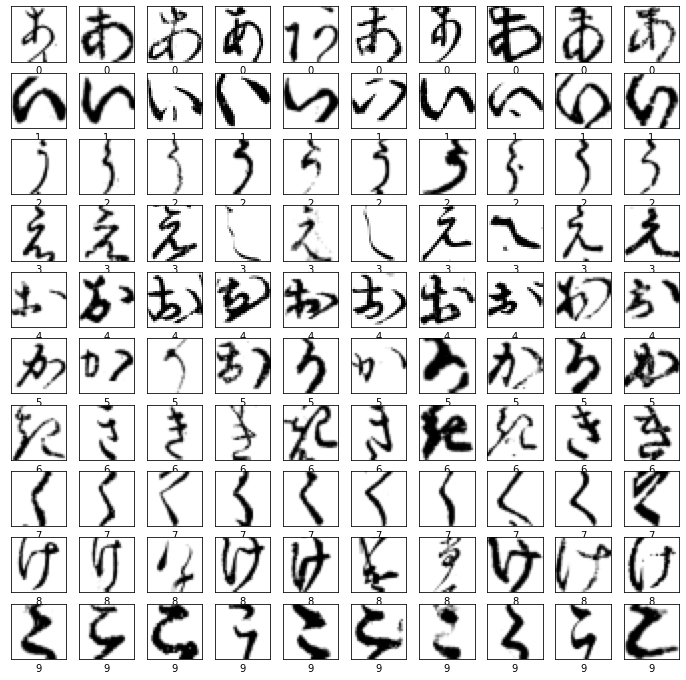

In [11]:
plot_sample_images_data(train_images,train_labels)

In [0]:
#taken from github.com/
def sampling(args):
  z_mean,z_log_var=args
  epsilon=K.random_normal(shape=(batch_size,latent_dim),mean=0.,stddev=epsilon_std)
  return z_mean+K.exp(z_log_var/2)*epsilon

In [0]:
def build_encoder():
  img=Input(shape=img_shape)
  h=Flatten()(img)
  h=Dense(512)(h)
  h=LeakyReLU(alpha=0.2)(h)
  h=Dense(512)(h)
  h=LeakyReLU(alpha=0.2)(h)
  mu=Dense(latent_dim)(h)
  log_var=Dense(latent_dim)(h)
  z=Lambda(sampling,output_shape=(latent_dim,),name='z')([mu,log_var])
  return Model(img,z)

In [0]:
def build_decoder():
  model=Sequential()
  model.add(Dense(512,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(np.prod(img_shape),activation='tanh'))
  model.add(Reshape(img_shape))
  #model.summary()
  z=Input(shape=(latent_dim,))
  img=model(z)
  return Model(z,img)

In [0]:
def build_discriminator():
  model=Sequential()
  model.add(Dense(1024,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  #model.summary()
  encoded_repr=Input(shape=(latent_dim,))
  validity=model(encoded_repr)
  return Model(encoded_repr,validity)

In [0]:
#build GAN
optimizer=Adam(0.0002, 0.5)

discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

encoder=build_encoder()
decoder=build_decoder()

img=Input(shape=img_shape)
encoded_repr=encoder(img)
reconstructed_img=decoder(encoded_repr)

#For the adversarial_autoencoder model we will only train the generator
#if discriminator is attached to generator, set this flag to fix discriminator
discriminator.trainable=False

validity=discriminator(encoded_repr)

adversarial_autoencoder=Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001], optimizer=optimizer)

In [0]:
#trainGAN
def train(epochs,batch_size=128,sample_interval=50):
  X_train=train_images

  #normalization (rescale -1 to 1)
  X_train=(X_train.astype(np.float32)-127.5)/127.5
  X_train=np.expand_dims(X_train,axis=3)

  #adversarial ground truths
  valid=np.ones((batch_size,1))
  fake=np.zeros((batch_size,1))

  for epoch in range(epochs):
    idx=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[idx]

    latent_fake=encoder.predict(imgs)
    latent_real=np.random.normal(size=(batch_size,latent_dim))

    #let latent's real output be close to 1
    d_loss_real=discriminator.train_on_batch(latent_real, valid)
    #let latent's fake output be close to 0
    d_loss_fake=discriminator.train_on_batch(latent_fake,fake)
    d_loss=0.7*np.add(d_loss_real,d_loss_fake)

    #train generator
    #decrease reconstruction error
    g_loss=adversarial_autoencoder.train_on_batch(imgs,[imgs,valid])

    if epoch%sample_interval==0:
      print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))
      sample_images(epoch)

In [0]:
def sample_images(epoch):
  r,c=5,5
  z=np.random.normal(size=(r*c,latent_dim))
  gen_imgs=decoder.predict(z)
  gen_imgs=0.5*gen_imgs+0.5
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap=plt.cm.binary)
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("kmnist_%d.png" % epoch)
  plt.close()


In [0]:
epochs=90000
sample_interval=2000
sample_count=epochs/sample_interval

In [0]:
train(epochs=epochs,batch_size=batch_size,sample_interval=sample_interval)

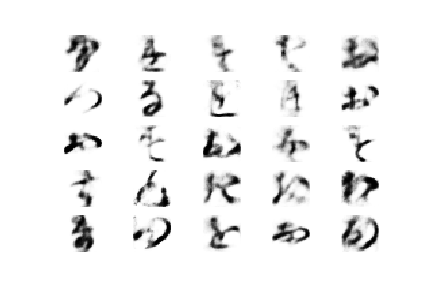

In [25]:
Image.open('mnist_88000.png')

Ref: 
<a href=https://github.com/eriklindernoren/Keras-GAN#adversarial-autoencoder> Keras Autoencoder </a>